In [1]:
import numpy as np
import bayes3d as b
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL
from PIL import Image
import os
import jax
import jax.numpy as jnp
import plotly.graph_objs as go
from scipy.spatial.transform import Rotation as R
import imageio
import io
from ll_viz import  *

In [3]:
# set up renderer
intrinsics = b.Intrinsics(
 height=100,
 width=100,
 fx=250, fy=250,
 cx=100/2.0, cy=100/2.0,
 near=0.1, far=20
)

b.setup_renderer(intrinsics)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj")
                                , scaling_factor=0.1, mesh_name = "cube_1")
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj")
                                , scaling_factor=0.1, mesh_name = "cube_2")

Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [11]:
##############################################################################################################
"""
Likelihood test case 1
Description: Observed image has one object, rendered image has no object in camera view
Expected behavior: The likelihood when the hypothesis image is the observed image should be higher than when the 
hypothesis image is the rendered image. The likelihood per pixel should also visually show this
"""
##############################################################################################################

def ll_testcase_1(ll_f, ll_f_per_pixel, ll_f_args, ll_f_per_pixel_args = None, scale = 2):
    if ll_f_per_pixel_args == None:
        ll_f_per_pixel_args = ll_f_args

    ll_test_num = 1
    # make poses intersect/collide/penetrate
    obs_pose = jnp.eye(4).at[:3,3].set([-0.15,0,1.5])
    obs_pose = obs_pose @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)
    # pose_2 = jnp.eye(4).at[:3,3].set([-0.05,0,1.5])
    # pose_2 = pose_2 @ b.transform_from_axis_angle(jnp.array([1,1,1]), jnp.pi/4)
    hypothesis_pose = jnp.eye(4).at[:3,3].set([-1,0,1.5])

    observed_image_PCL = b.RENDERER.render(jnp.stack([obs_pose]), jnp.array([0]))[...,:3]
    hypothesis_image_PCL = b.RENDERER.render(jnp.stack([hypothesis_pose]), jnp.array([0]))[...,:3]

    ll_good = ll_f(observed_image_PCL, observed_image_PCL, *ll_f_args)
    ll_bad = ll_f(observed_image_PCL, hypothesis_image_PCL, *ll_f_args)

    assert ll_good > ll_bad
    print(f"The likelihood with the object in the correct pose is {ll_good}, while the likelihood for the object not in scene is {ll_bad}")

    ll_per_pixel = ll_f_per_pixel(observed_image_PCL, hypothesis_image_PCL, *ll_f_per_pixel_args)
    ll_viz = get_bayes3d_grid_PIL_frame(np.array(ll_per_pixel), scale)

    return b.multi_panel([b.scale_image(b.get_depth_image(observed_image_PCL[...,2]),scale*2),
                    b.scale_image(b.get_depth_image(hypothesis_image_PCL[...,2]),scale*2),
                    b.scale_image(ll_viz,2)],
                    labels = ['Observed', 'Hypothesis', 'Likelihood'],
                    title = 'Likelihood test {}'.format(ll_test_num))

The likelihood with the object in the correct pose is 10.0, while the likelihood for the object not in scene is 9.531000137329102


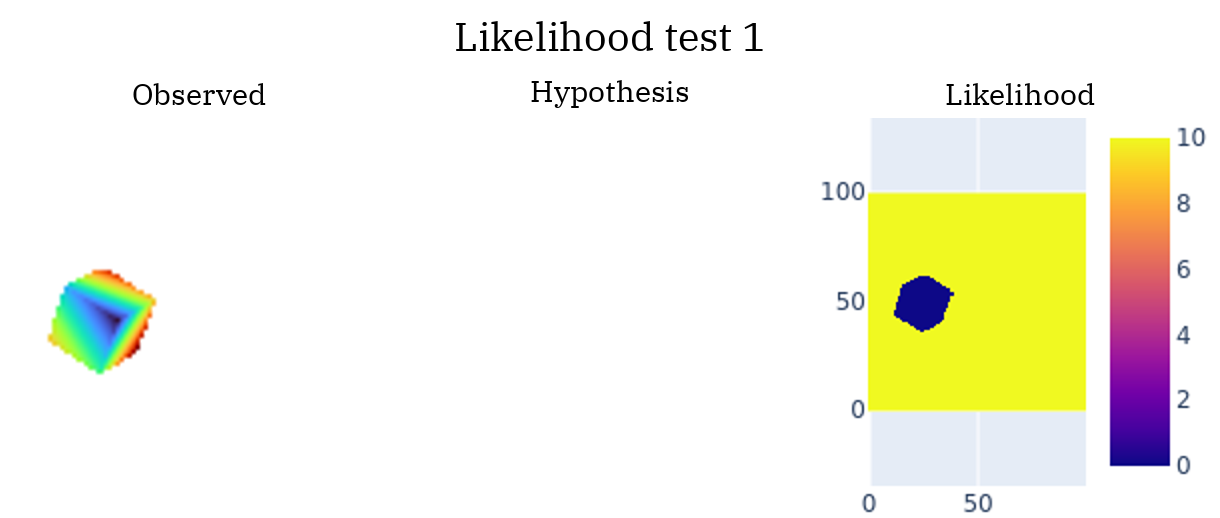

In [14]:
# Test with new ll
variance = 0.1
ll_f = b.threedp3_likelihood
ll_f_per_pixel = b.threedp3_likelihood_per_pixel
ll_f_args = (variance, None)
ll_testcase_1(ll_f, ll_f_per_pixel, ll_f_args, scale = 2)

The likelihood with the object in the correct pose is -16065.185546875, while the likelihood for the object not in scene is -21791.203125


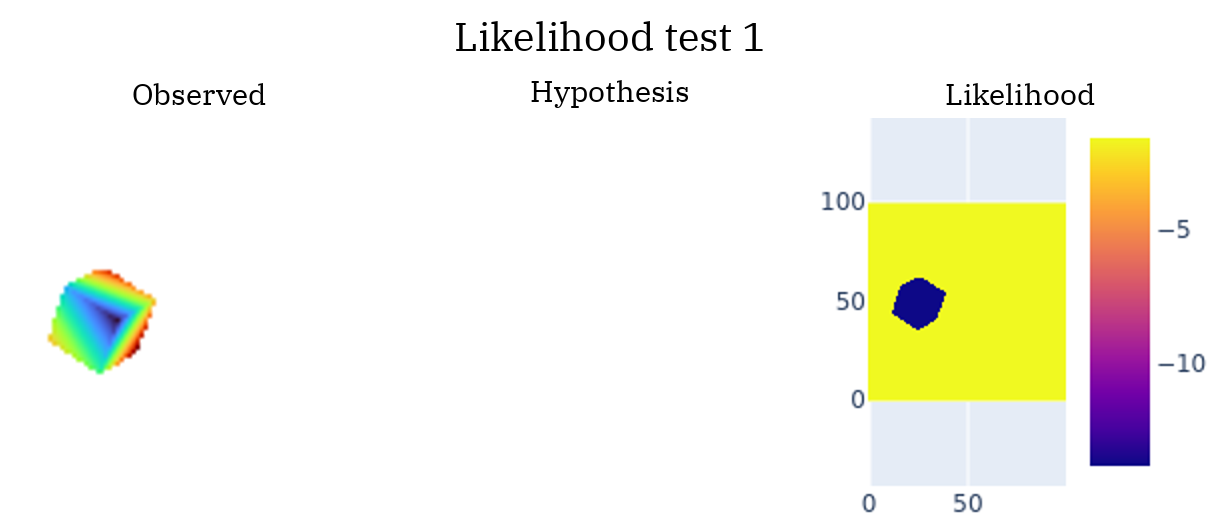

In [15]:
# Test with old ll
variance = 0.1
ll_f = b.threedp3_likelihood_old
ll_f_per_pixel = b.threedp3_likelihood_per_pixel_old
ll_f_args = (0.001,0.001,1000,None,3)
ll_f_per_pixel_args = (0.001,0.001,1000,3)
ll_testcase_1(ll_f, ll_f_per_pixel, ll_f_args, ll_f_per_pixel_args, scale = 2)